Source: https://www.nltk.org/nltk_data/

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /home/loong/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
print(torch.cuda.is_available())

True


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

## Task 1

### 1. Skipgram

In [5]:
# limit the number of sentences to 400
news_corpus = brown.sents(categories='news')[:400]
news_corpus

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [6]:
# flatten the list of lists
flatten = lambda l: [item for sublist in l for item in sublist]
news_vocab = list(set(flatten(news_corpus)))
news_vocab

['excise',
 'They',
 'experienced',
 'appointing',
 'correspondent',
 'hailed',
 'Summerdale',
 'Customary',
 'Relatively',
 'timely',
 'topics',
 'manifestations',
 'amount',
 'management',
 'observers',
 'handling',
 'Nov.',
 'imposed',
 'tragedies',
 'permit',
 'Kika',
 '50',
 'core',
 'matters',
 'contracts',
 'American',
 'coolest',
 'Clements',
 'Weatherford',
 'impair',
 'fixed',
 'Clark',
 'since',
 'sponsored',
 'ago',
 'excuses',
 'Ridge',
 'local',
 'In',
 'health',
 'When',
 'does',
 'Health',
 'illegitimacy',
 'such',
 'controversy',
 'revamped',
 'half',
 '13',
 'Williams',
 'any',
 'storage',
 'viewed',
 'clerical',
 'Tarrant',
 'unconstitutional',
 'race',
 'sending',
 'levy',
 'reduce',
 'ballot',
 'persuade',
 'disposal',
 'persons',
 'medicine',
 'hurdle',
 'highways',
 'passed',
 'stays',
 'after',
 'evidence',
 'outright',
 'gave',
 'registered',
 'consistently',
 'construction',
 'anyone',
 'Many',
 'unity',
 'daughter',
 'students',
 'tossed',
 'many',
 'pertaine

In [7]:
news_vocab.append('<UNK>')

In [8]:
#numericalization
word2idx = {word: idx for idx, word in enumerate(news_vocab)}
print(word2idx)

{'excise': 0, 'They': 1, 'experienced': 2, 'appointing': 3, 'correspondent': 4, 'hailed': 5, 'Summerdale': 6, 'Customary': 7, 'Relatively': 8, 'timely': 9, 'topics': 10, 'manifestations': 11, 'amount': 12, 'management': 13, 'observers': 14, 'handling': 15, 'Nov.': 16, 'imposed': 17, 'tragedies': 18, 'permit': 19, 'Kika': 20, '50': 21, 'core': 22, 'matters': 23, 'contracts': 24, 'American': 25, 'coolest': 26, 'Clements': 27, 'Weatherford': 28, 'impair': 29, 'fixed': 30, 'Clark': 31, 'since': 32, 'sponsored': 33, 'ago': 34, 'excuses': 35, 'Ridge': 36, 'local': 37, 'In': 38, 'health': 39, 'When': 40, 'does': 41, 'Health': 42, 'illegitimacy': 43, 'such': 44, 'controversy': 45, 'revamped': 46, 'half': 47, '13': 48, 'Williams': 49, 'any': 50, 'storage': 51, 'viewed': 52, 'clerical': 53, 'Tarrant': 54, 'unconstitutional': 55, 'race': 56, 'sending': 57, 'levy': 58, 'reduce': 59, 'ballot': 60, 'persuade': 61, 'disposal': 62, 'persons': 63, 'medicine': 64, 'hurdle': 65, 'highways': 66, 'passed':

In [9]:
#vocab size
voc_size = len(word2idx)
print(voc_size)

2550


In [10]:
index2word = {v:k for k,v in word2idx.items()}

#### Prepare train data

In [11]:
def random_batch(batch_size, corpus, window_size=2):
    # Make skip gram of custom size window
    skip_grams = []

    for sent in corpus:
        for target_index in range(window_size, len(sent) - window_size):
            target = word2idx[sent[target_index]]
            context = []
            count = window_size # count of context words to pick on the left and right
            # to pick the default window size of 2 words on the left and right of the target word and second word on the left and right
            while count > 0:
                context.append(word2idx[sent[target_index - count]])
                context.append(word2idx[sent[target_index + count]])
                count -= 1

            for word in context:
                skip_grams.append([target, word])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]]) 
        random_labels.append([skip_grams[i][1]])  
            
    return np.array(random_inputs), np.array(random_labels)

#### test

In [12]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, news_corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[391]
 [982]]
Target:  [[2324]
 [1453]]


#### model

In [13]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.center_embedding = nn.Embedding(vocab_size, emb_size)
        self.outside_embedding = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.center_embedding(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.outside_embedding(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.outside_embedding(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

#### training

In [16]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model_skip_gram          = Skipgram(voc_size, embedding_size)
model_skip_gram = model_skip_gram.to(device)

optimizer = optim.Adam(model_skip_gram.parameters(), lr=0.001)

In [17]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(news_vocab), word2idx).expand(batch_size, len(news_vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 2550])

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [87]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, news_corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    all_vocabs = all_vocabs.to(device)
    loss = model_skip_gram(input_batch, target_batch, all_vocabs)

    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

TypeError: random_batch() missing 3 required positional arguments: 'skip_grams', 'X_ik', and 'weighting_dic'

#### plotting the embedigs

In [19]:
#list of vocabs
news_vocab[:10]

['excise',
 'They',
 'experienced',
 'appointing',
 'correspondent',
 'hailed',
 'Summerdale',
 'Customary',
 'Relatively',
 'timely']

In [24]:
word = news_vocab[0]
id = word2idx[word]
id

0

In [25]:
id_tensor = torch.LongTensor([id])
id_tensor= id_tensor.to(device)
id_tensor

tensor([0], device='cuda:0')

In [26]:
#get the embedding by averaging
v_embed = model_skip_gram.center_embedding(id_tensor)
v_embed = v_embed.to(device)
u_embed = model_skip_gram.outside_embedding(id_tensor)
u_embed = u_embed.to(device)



v_embed, u_embed

(tensor([[1.3500, 0.8129]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[1.3796, 0.4899]], device='cuda:0', grad_fn=<EmbeddingBackward0>))

In [27]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.6514, device='cuda:0', grad_fn=<SelectBackward0>)

In [28]:
#function to get embedding given a word
def get_embed_skip_gram(word):
    id_tensor = torch.LongTensor([word2idx[word]])
    id_tensor = id_tensor.to(device)
    v_embed = model_skip_gram.center_embedding(id_tensor)
    u_embed = model_skip_gram.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

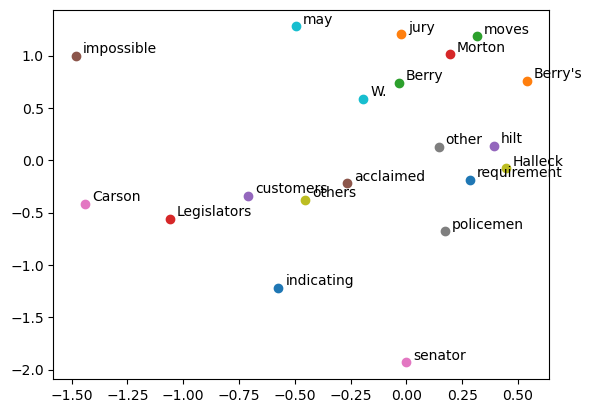

In [56]:
# plt.figure(figsize=(6,3))
for i, word in enumerate(news_vocab[:20]): #loop each unique vocab
    x, y = get_embed_skip_gram(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

#### cosine similaruty

In [20]:
news_vocab

['excise',
 'They',
 'experienced',
 'appointing',
 'correspondent',
 'hailed',
 'Summerdale',
 'Customary',
 'Relatively',
 'timely',
 'topics',
 'manifestations',
 'amount',
 'management',
 'observers',
 'handling',
 'Nov.',
 'imposed',
 'tragedies',
 'permit',
 'Kika',
 '50',
 'core',
 'matters',
 'contracts',
 'American',
 'coolest',
 'Clements',
 'Weatherford',
 'impair',
 'fixed',
 'Clark',
 'since',
 'sponsored',
 'ago',
 'excuses',
 'Ridge',
 'local',
 'In',
 'health',
 'When',
 'does',
 'Health',
 'illegitimacy',
 'such',
 'controversy',
 'revamped',
 'half',
 '13',
 'Williams',
 'any',
 'storage',
 'viewed',
 'clerical',
 'Tarrant',
 'unconstitutional',
 'race',
 'sending',
 'levy',
 'reduce',
 'ballot',
 'persuade',
 'disposal',
 'persons',
 'medicine',
 'hurdle',
 'highways',
 'passed',
 'stays',
 'after',
 'evidence',
 'outright',
 'gave',
 'registered',
 'consistently',
 'construction',
 'anyone',
 'Many',
 'unity',
 'daughter',
 'students',
 'tossed',
 'many',
 'pertaine

In [30]:
spark = get_embed_skip_gram('spark')
divorce = get_embed_skip_gram('divorce')
April = get_embed_skip_gram('April')

In [31]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"April vs. spark: ",        cos_sim(April, spark))
print(f"divorce vs. April: ",       cos_sim(divorce, April))
print(f"April vs. April: ",          cos_sim(April, April))

April vs. spark:  -0.8462830206062654
divorce vs. April:  0.9277607470737866
April vs. April:  1.0000000000000002


In [32]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"April vs. spark: ",        cos_sim(April, spark))
print(f"divorce vs. April: ",       cos_sim(divorce, April))
print(f"April vs. April: ",          cos_sim(April, April))

April vs. spark:  -0.8462830206062653
divorce vs. April:  0.9277607470737866
April vs. April:  1.0


### 2.Negative sampling

In [33]:
Z = 0.001

In [34]:
#count
from collections import Counter

word_count = Counter(flatten(news_corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

9101

In [35]:
unigram_table = []

for v in news_vocab:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / Z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'the': 116,
         ',': 91,
         '.': 85,
         'of': 75,
         'to': 62,
         'a': 51,
         'in': 49,
         'and': 47,
         'for': 33,
         '``': 33,
         "''": 32,
         'The': 30,
         'that': 29,
         'by': 25,
         'would': 24,
         'on': 23,
         'was': 22,
         'said': 22,
         'be': 21,
         'as': 20,
         'is': 19,
         'has': 17,
         'he': 16,
         'it': 15,
         'not': 14,
         'been': 14,
         'will': 14,
         'his': 13,
         'an': 13,
         'with': 13,
         'at': 13,
         'which': 13,
         'this': 12,
         'President': 11,
         'from': 11,
         'administration': 11,
         'who': 11,
         'year': 11,
         'have': 10,
         'or': 10,
         'jury': 10,
         'more': 10,
         'its': 10,
         'House': 10,
         'Texas': 10,
         'had': 10,
         '--': 10,
         'State': 9,
         'plan': 9,
    

#### Model

In [36]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [37]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2idx).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [38]:
batch_size = 2
x, y = random_batch(batch_size, news_corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [42]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [39]:
y_tensor[1]

tensor([1720])

In [43]:
neg_samples[1]

tensor([ 782, 2016, 2452, 1939, 2371])

In [44]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.center_embedding = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.center_embedding(center) #(bs, 1, emb_size)
        outside_embed  = self.outside_embedding(outside) #(bs, 1, emb_size)
        negative_embed = self.outside_embedding(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [45]:
#test your model
emb_size = 2
voc_size = len(news_vocab)
model_negative_samp= SkipgramNeg(voc_size, emb_size)

In [46]:
loss = model_negative_samp(x_tensor, y_tensor, neg_samples)

In [47]:
loss

tensor(3.5966, grad_fn=<NegBackward0>)

#### Training

In [48]:
optimizer = optim.Adam(model_negative_samp.parameters(), lr=0.001)

In [49]:
num_epochs = 5000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, news_corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model_negative_samp(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 4.689713
Epoch   2000 | Loss: 1.985670
Epoch   3000 | Loss: 4.275100
Epoch   4000 | Loss: 2.948280
Epoch   5000 | Loss: 0.787145


In [50]:
news_vocab

['excise',
 'They',
 'experienced',
 'appointing',
 'correspondent',
 'hailed',
 'Summerdale',
 'Customary',
 'Relatively',
 'timely',
 'topics',
 'manifestations',
 'amount',
 'management',
 'observers',
 'handling',
 'Nov.',
 'imposed',
 'tragedies',
 'permit',
 'Kika',
 '50',
 'core',
 'matters',
 'contracts',
 'American',
 'coolest',
 'Clements',
 'Weatherford',
 'impair',
 'fixed',
 'Clark',
 'since',
 'sponsored',
 'ago',
 'excuses',
 'Ridge',
 'local',
 'In',
 'health',
 'When',
 'does',
 'Health',
 'illegitimacy',
 'such',
 'controversy',
 'revamped',
 'half',
 '13',
 'Williams',
 'any',
 'storage',
 'viewed',
 'clerical',
 'Tarrant',
 'unconstitutional',
 'race',
 'sending',
 'levy',
 'reduce',
 'ballot',
 'persuade',
 'disposal',
 'persons',
 'medicine',
 'hurdle',
 'highways',
 'passed',
 'stays',
 'after',
 'evidence',
 'outright',
 'gave',
 'registered',
 'consistently',
 'construction',
 'anyone',
 'Many',
 'unity',
 'daughter',
 'students',
 'tossed',
 'many',
 'pertaine

In [51]:
# embedding of the word for negative sampling
def get_embed_negative_sampling(word):
    try:
        index = word2idx[word]
    except:
        index = word2idx['<UNK>']
        
    word = torch.LongTensor([word2idx[word]])
    
    embed_c = model_negative_samp.center_embedding(word)
    embed_o = model_negative_samp.outside_embedding(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()


### Glove

#### build Co-occurence Matrix X

In [52]:
from collections import Counter

X_i = Counter(flatten(news_corpus))
X_i

Counter({'the': 518,
         ',': 377,
         '.': 342,
         'of': 292,
         'to': 227,
         'a': 174,
         'in': 166,
         'and': 158,
         'for': 99,
         '``': 97,
         "''": 94,
         'The': 87,
         'that': 84,
         'by': 68,
         'would': 65,
         'on': 61,
         'said': 59,
         'was': 57,
         'be': 56,
         'as': 50,
         'is': 49,
         'has': 42,
         'he': 37,
         'it': 36,
         'been': 32,
         'will': 32,
         'not': 31,
         'an': 30,
         'which': 29,
         'his': 29,
         'at': 28,
         'with': 28,
         'this': 26,
         'administration': 25,
         'from': 24,
         'who': 24,
         'year': 23,
         'President': 23,
         'jury': 22,
         'have': 22,
         'Texas': 22,
         '--': 22,
         'its': 21,
         'had': 20,
         'or': 20,
         'more': 20,
         'House': 20,
         'State': 19,
         'plan':

In [53]:
def glove_skipgram(window_size=2):
    # Make skip gram of custom size window
    skip_grams = []

    for sent in news_corpus:
        for target_index in range(window_size, len(sent) - window_size):
            target = sent[target_index]
            context = []
            count = window_size # count of context words to pick on the left and right
            while count > 0:
                # for default window, it will get the left most and right most word
                # then the second left most and second right most word
                context.append(sent[target_index - count])
                context.append(sent[target_index + count])
                count -= 1

            for word in context:
                skip_grams.append((target, word))
    return skip_grams

In [54]:
skip_grams = glove_skipgram(2)
skip_grams

[('County', 'The'),
 ('County', 'Jury'),
 ('County', 'Fulton'),
 ('County', 'Grand'),
 ('Grand', 'Fulton'),
 ('Grand', 'said'),
 ('Grand', 'County'),
 ('Grand', 'Jury'),
 ('Jury', 'County'),
 ('Jury', 'Friday'),
 ('Jury', 'Grand'),
 ('Jury', 'said'),
 ('said', 'Grand'),
 ('said', 'an'),
 ('said', 'Jury'),
 ('said', 'Friday'),
 ('Friday', 'Jury'),
 ('Friday', 'investigation'),
 ('Friday', 'said'),
 ('Friday', 'an'),
 ('an', 'said'),
 ('an', 'of'),
 ('an', 'Friday'),
 ('an', 'investigation'),
 ('investigation', 'Friday'),
 ('investigation', "Atlanta's"),
 ('investigation', 'an'),
 ('investigation', 'of'),
 ('of', 'an'),
 ('of', 'recent'),
 ('of', 'investigation'),
 ('of', "Atlanta's"),
 ("Atlanta's", 'investigation'),
 ("Atlanta's", 'primary'),
 ("Atlanta's", 'of'),
 ("Atlanta's", 'recent'),
 ('recent', 'of'),
 ('recent', 'election'),
 ('recent', "Atlanta's"),
 ('recent', 'primary'),
 ('primary', "Atlanta's"),
 ('primary', 'produced'),
 ('primary', 'recent'),
 ('primary', 'election'),
 (

In [55]:
X_ik_skipgrams = Counter(skip_grams) # Call the function
print(X_ik_skipgrams)

Counter({('the', 'of'): 137, ('of', 'the'): 136, ('the', ','): 77, (',', 'the'): 77, ('the', 'in'): 69, ('in', 'the'): 69, ('to', 'the'): 58, ('the', 'to'): 58, (',', ','): 48, ('a', 'of'): 38, ('of', 'a'): 38, (',', 'and'): 38, ('and', ','): 38, ('of', ','): 35, (',', 'of'): 35, ('a', ','): 33, (',', 'a'): 33, ('the', 'and'): 31, ('and', 'the'): 31, ('that', 'the'): 30, ('the', 'that'): 30, ('the', 'for'): 30, ('for', 'the'): 29, (',', 'said'): 27, ('said', ','): 26, ('to', 'a'): 25, ('on', 'the'): 25, ('the', 'on'): 25, ('a', 'to'): 24, ('the', '.'): 24, ("''", ','): 21, (',', "''"): 21, ('been', 'has'): 20, ('the', "''"): 18, ('has', 'been'): 18, (',', 'in'): 18, ('in', ','): 18, ('be', 'would'): 18, ('the', 'said'): 17, ('``', 'the'): 16, ('the', '``'): 16, ('by', 'the'): 16, ('the', 'by'): 16, ('and', 'of'): 15, ('of', 'and'): 15, ("''", 'the'): 15, ('at', 'the'): 15, ('the', 'at'): 15, ('the', 'administration'): 15, ('would', 'be'): 15, ('he', ','): 15, ('``', "''"): 14, ('admini

#### Weighting function

In [56]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [57]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(news_vocab, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

#### Prepare the data 

In [58]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2idx[skip_gram[0]], word2idx[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

#### Testing the method

In [59]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, news_corpus, skip_grams, X_ik, weighting_dic)

In [60]:
print("X: ", x)
print("Y: ", y)
print("Cooc: ", cooc)
print("Weighting: ", weighting)

X:  [[2145]
 [ 477]]
Y:  [[1670]
 [1700]]
Cooc:  [[1.09861229]
 [0.69314718]]
Weighting:  [[0.07208434]
 [0.05318296]]


#### Model

In [61]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [62]:
#test our system
voc_size = len(news_vocab)
emb_size = 2
model_glove = Glove(voc_size, emb_size)

In [63]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [64]:
oss = model_glove(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

#### Training

In [65]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model_glove = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_glove.parameters(), lr=0.001)

In [66]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, news_corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model_glove(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | cost: 3.050524 | time: 0m 0s
Epoch: 2000 | cost: 61.776684 | time: 0m 0s
Epoch: 3000 | cost: 4.274026 | time: 0m 0s
Epoch: 4000 | cost: 1.803222 | time: 0m 0s
Epoch: 5000 | cost: 0.981114 | time: 0m 0s


In [68]:
def get_embed_glove(word):
    id_tensor = torch.LongTensor([word2idx[word]])
    v_embed = model_glove.center_embedding(id_tensor)
    u_embed = model_glove.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

### Glove(Gensim)

In [69]:
import gensim.downloader as api

model_glove_gensim = api.load("glove-wiki-gigaword-100")


## Task 2

### Evaluation Methods

In [70]:
def predict_word(word1, word2, word3, embeddings, word_to_index, index_to_word):
    # Get vectors for w1, w2, w3
    vec1 = np.array(embeddings(word1))
    vec2 = np.array(embeddings(word2))
    vec3 = np.array(embeddings(word3))

    # Calculate the predicted vector
    predicted_vec = vec1 - vec2 + vec3

    # Find the closest word by cosine similarity
    max_similarity = -1
    best_word = None
    for word, index in word_to_index.items():
        if word in [word1, word2, word3]:  # Skip the input words
            continue
        similarity = cos_sim(predicted_vec, embeddings(word))
        if similarity > max_similarity:
            max_similarity = similarity
            best_word = word

    return best_word

In [71]:
# Evaluate accuracy
def evaluate_analogies(analogy_dataset, embeddings, word_to_index):
    correct = 0
    total = 0

    for analogy in analogy_dataset:
        word1, word2, word3, word4 = analogy
        if word1 not in word_to_index or word2 not in word_to_index or word3 not in word_to_index or word4 not in word_to_index:
            continue  # Skip if any word is not in the vocabulary
        predicted_word = predict_word(word1, word2, word3, embeddings, word_to_index, {v: k for k, v in word_to_index.items()})
        if predicted_word == word4:
            correct += 1
        total += 1

    return correct / total if total > 0 else 0

In [72]:
def calculate_accuracy_gensim(dataset, model):
    correct = 0
    total = 0

    for analogy in dataset:
        word1, word2, word3, word4 = analogy

        # Check if all words exist in the model's vocabulary
        if all(word in model for word in [word1, word2, word3, word4]):
            # Vector arithmetic: w3 + w2 - w1
            predicted_word = model.most_similar(positive=[word3, word2], negative=[word1], topn=1)[0][0]

            if predicted_word == word4:
                correct += 1

        total += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

In [77]:
filepath = "/mnt/d/project/nlp/a1/word-test.v1.txt"


# Read the content of the file
with open(filepath, 'r') as file:
    # Skip the first line
    file.readline()

    # Read the remaining content of the file
    file_content = file.readlines()

# Initialize variables to store relevant lines
total_corpus = []

# Variable to keep track of the current heading
current_heading = None

# Iterate through each line in the file content
for line in file_content:
    # Check if the line is a heading
    if line.startswith(':'):
        current_heading = line.strip()
    else:
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        total_corpus.append(words)

In [78]:
filepath = "/mnt/d/project/nlp/a1/word-test.v1.txt"

# Read the content of the file
with open(filepath, 'r') as file:
    file_content = file.readlines()

# Initialize variables to store relevant lines
capital_common_countries = []
past_tense = []

# Variable to keep track of the current heading
current_heading = None

# Iterate through each line in the file content
for line in file_content:
    # Check if the line is a heading
    if line.startswith(':'):
        current_heading = line.strip()
    elif current_heading == ': capital-common-countries':
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        capital_common_countries.append(words)
    elif current_heading == ': gram7-past-tense':
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        past_tense.append(words)



#### Semantic Accuracy

In [79]:
semantic_accuracy_skip_gram= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Semantic accuracy (Skip-gram): {semantic_accuracy_skip_gram:.2f}%")

Semantic accuracy (Skip-gram): 0.02%


In [80]:
semantic_accuracy_neg_samp= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Semantic accuracy (Skip-gram_neg_samp): {semantic_accuracy_neg_samp:.2f}%")

Semantic accuracy (Skip-gram_neg_samp): 0.02%


In [81]:
semantic_accuracy_glove= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Semantic accuracy (glove: {semantic_accuracy_glove:.2f}%")

Semantic accuracy (glove: 0.02%


In [82]:
semantic_accuracy_glove_gensim= calculate_accuracy_gensim(total_corpus,model_glove_gensim)
print(f"Semantic accuracy (glove_gensim): {semantic_accuracy_glove_gensim:.2f}%")

Semantic accuracy (glove_gensim): 63.11%


#### Syntatic Accuracy

In [3]:
syntatic_accuracy_skip_gram= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Syntatic accuracy (Skip-gram): {syntatic_accuracy_skip_gram:.2f}%")

NameError: name 'evaluate_analogies' is not defined

In [ ]:
syntatic_accuracy_skip_gram_neg_samp= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Syntatic accuracy (Skip-gram_neg_samp): {syntatic_accuracy_skip_gram_neg_samp:.2f}%")

Syntatic accuracy (Skip-gram_neg_samp): 0.02%


In [ ]:
syntatic_accuracy_glove= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Syntatic accuracy (glove): {syntatic_accuracy_glove:.2f}%")

Syntatic accuracy (glove): 0.02%


In [ ]:
syntatic_accuracy_glove_gensim= calculate_accuracy_gensim(total_corpus,model_glove_gensim)
print(f"Syntatic accuracy (glove_gensim): {syntatic_accuracy_glove_gensim:.2f}%")

Syntatic accuracy (glove_gensim): 63.11%


| Model            | Window Size | Training Loss | Training Time (Sec) | Syntactic Accuracy | Semantic Accuracy |
|------------------|-------------|---------------|---------------------|--------------------|-------------------|
| Skipgram         | 2           | 7.36          | 420                 | 0.02%                 | 0.02%                |
| Skipgram (NEG)   | 2           | 0.78          | 405                 | 0.02%                 | 0.02%                |
| GloVe            | –           | 0.98          | 90                  | 0.02%                 | 0.02%                |
| GloVe (Gensim)   | –           | –             | –                   | 63.11%             | 63.11%            |


### Spearman Coefficient

In [ ]:
import pandas as pd

file_path = 'wordsim_similarity_goldstandard.txt'

# Define the column names
columns = ['word_1', 'word_2', 'similarity_index']

# Read the text file into a pandas DataFrame with specified column names
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

df

In [ ]:
# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    word_1 = row['word_1']
    word_2 = row['word_2']

    try:
        # Attempt to get embeddings and compute the dot product
        embed_1_skip_gram = get_embed_skip_gram(word_1)
        embed_2_skip_gram = get_embed_skip_gram(word_2)
        embed_1_neg_samp = get_embed_negative_sampling(word_1)
        embed_2_neg_samp = get_embed_negative_sampling(word_2)
        embed_1_glove = get_embed_glove(word_1)
        embed_2_glove = get_embed_glove(word_2)

    except KeyError:
        # Handle the case where one or both words are not present in the model
        # Replace missing embeddings with the embedding of '<UNK>' or any other suitable value
        embed_1_skip_gram = get_embed_skip_gram('<UNK>')
        embed_2_skip_gram = get_embed_skip_gram('<UNK>')
        embed_1_neg_samp = get_embed_negative_sampling('<UNK>')
        embed_2_neg_samp = get_embed_negative_sampling('<UNK>')
        embed_1_glove = get_embed_glove('<UNK>')
        embed_2_glove = get_embed_glove('<UNK>')

    # Compute the dot product and update the DataFrame
    df.at[index, 'dot_product_skip_gram'] = np.dot(embed_1_skip_gram, embed_2_skip_gram)
    df.at[index, 'dot_product_neg_samp'] = np.dot(embed_1_neg_samp, embed_2_neg_samp)
    df.at[index, 'dot_product_glove'] = np.dot(embed_1_glove, embed_2_glove)

df[:10]

In [ ]:
from scipy.stats import spearmanr

# Compute the Spearman correlation between the provided similarity scores and your models' dot products
correlation_skip_gram, _ = spearmanr(df['similarity_index'], df['dot_product_skip_gram'])
correlation_neg_samp, _ = spearmanr(df['similarity_index'], df['dot_product_neg_samp'])
correlation_glove, _ = spearmanr(df['similarity_index'], df['dot_product_glove'])


# Display the correlation coefficient
print(f"Spearman Correlation Coefficient of Skipgram: {correlation_skip_gram:.4f}")
print(f"Spearman Correlation Coefficient of Skipgram_neg_samp : {correlation_neg_samp:.4f}")
print(f"Spearman Correlation Coefficient of Glove: {correlation_glove:.4f}")

In [ ]:
# Finding y_true based on the mean of similarity index in the df
y_true = df['similarity_index'].mean()

print(f"y_true: {y_true:.2f}")

In [ ]:
# Using the correlation coeffiecient of the gensim model using the predefined function
correlation_coefficient = model_glove_gensim.evaluate_word_pairs('wordsim_similarity_goldstandard.txt')
print(f"Correlation coefficient: {correlation_coefficient[1][0]:.2f}")

In [ ]:
def get_embed_for_corpus(model, words):
    embeddings = {}

    for word in words:
        try:
            index = word2idx[word]
        except KeyError:
            index = word2idx['<UNK>']
            
        word_tensor = torch.LongTensor([index])
        word_tensor = word_tensor.to(device)
        
        model = model.to(device)

        embed_c = model.center_embedding(word_tensor)
        embed_o = model.outside_embedding(word_tensor)
        embed = (embed_c + embed_o) / 2


        embeddings[word] = np.array([embed[0][0].item(), embed[0][1].item()])

    return embeddings

In [ ]:
embed_whole_glove = get_embed_for_corpus(model_glove, news_vocab)
embed_whole_neg_samp = get_embed_for_corpus(model_negative_samp, news_vocab)
embed_whole_skip_gram = get_embed_for_corpus(model_skip_gram, news_vocab)

| Model | Skipgram (POS) | Skipgram (NEG) | GloVe | GloVe (gensim) | Y true |
|------|----------------|---------------|-------|---------------|--------|
| MSE  | -0.0217        | 0.0713        | 0.0076| 0.60          | 5.13   |


### Inference

In [ ]:
import os
os.makedirs("model", exist_ok=True)

In [ ]:
import pickle

gensim_model_path = 'model/model_gensim.pkl'

with open(gensim_model_path, 'wb') as model_file:
    pickle.dump(model_glove_gensim, model_file)

print(f"Gensim model saved to: {gensim_model_path}")


In [ ]:
pickle_file_path = 'model/embed_skipgram.pkl'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embed_whole_skip_gram, pickle_file)

print(f"Embedding dictionary saved to: {pickle_file_path}")


In [ ]:
pickle_file_path = 'model/embed_negative_samp.pkl'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embed_whole_neg_samp, pickle_file)

print(f"Embedding dictionary saved to: {pickle_file_path}")


In [ ]:
pickle_file_path = 'model/embed_glove.pkl'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embed_whole_glove, pickle_file)

print(f"Embedding dictionary saved to: {pickle_file_path}")


In [ ]:
with open('model/model_gensim.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('model/embed_skipgram.pkl', 'rb') as f:
    embedding_dict_neg = pickle.load(f)

with open('model/embed_negative_samp.pkl', 'rb') as f:
    embedding_dict_pos = pickle.load(f)

with open('model/embed_glove.pkl', 'rb') as f:
    embedding_dict_glove = pickle.load(f)
